In [3]:
import os
import json
import pandas as pd
import numpy as np
import scipy as sp
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Metrics obtained from an organizer of the Challenge
# https://github.com/plamere/RecsysChallengeTools/blob/master/metrics.py
from metrics import r_precision
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Loading the data from Million Playlist Dataset

#### Set max files for quick processing accordingly for quicker runtime of computationally intensive cells

In [4]:
playlists = list()
tracks = dict()
map_pl = list()

max_files_for_quick_processing = 0


def process_track(track):
    key = track['track_uri']
    if not key in tracks:
        tk = dict()
        tk['track_artist_name'] = track['artist_name']
        tk['track_artist_uri'] = track['artist_uri']
        tk['track_name'] = track['track_name']
        tk['track_album_uri'] = track['album_uri']
        tk['track_duration_ms'] = track['duration_ms']
        tk['track_album_name'] = track['album_name']
        tracks[track['track_uri']] = tk
    return key


def process_playlist(playlist):
    pl = dict()
    pl['playlist_name'] = playlist['name']
    pl['playlist_collaborative'] = playlist['collaborative']
    pl['playlist_pid'] = playlist['pid']
    pl['playlist_modified_at'] = playlist['modified_at']
    pl['playlist_num_albums'] = playlist['num_albums']
    pl['playlist_num_tracks'] = playlist['num_tracks']
    pl['playlist_num_followers'] = playlist['num_followers']
    pl['playlist_num_edits'] = playlist['num_edits']
    pl['playlist_duration_ms'] = playlist['duration_ms']
    pl['playlist_num_artists'] = playlist['num_artists']
    if 'description' in playlist:
        pl['playlist_description'] = playlist['description']
    else:
        pl['playlist_description'] = ''
    trks = list()
    for track in playlist['tracks']:
        map_pl.append([playlist['pid'], track['track_uri']])
        trks.append(track['track_uri'])
        process_track(track)
    return pl

def process_mpd(path):
    count = 0
    filenames = os.listdir(path)
    for filename in sorted(filenames):
        print(filename)
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            fullpath = os.sep.join((path, filename))
            f = open(fullpath)
            js = f.read()
            f.close()
            slice = json.loads(js)
            for playlist in slice['playlists']:
                playlists.append(process_playlist(playlist))
            count += 1
            if quick and count > max_files_for_quick_processing:
                break

quick = True
process_mpd('mpd.v1/data')

mpd.slice.0-999.json


In [5]:
print("The number of playlists we have decided to load is:  ", len(playlists), "\n")
print("The number of unique tracks loaded is:  ", len(tracks), "\n")
print("The map that will connect tracks to playlist has length:  ", len(map_pl))

The number of playlists we have decided to load is:   1000 

The number of unique tracks loaded is:   34443 

The map that will connect tracks to playlist has length:   67503


### We turn a list of playlist dictionaries into a dataframe

In [6]:
playlist_df = pd.DataFrame(playlists)
display(playlist_df.head())
display(playlist_df.describe())

,playlist_collaborative,playlist_description,playlist_duration_ms,playlist_modified_at,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_pid
0,false,,11532414,1493424000,Throwbacks,47,37,6,1,52,0
1,false,,11656470,1506556800,Awesome Playlist,23,21,5,1,39,1
2,false,,14039958,1505692800,korean,51,31,18,1,64,2
3,false,,28926058,1501027200,mat,107,86,4,1,126,3
4,false,,4335282,1401667200,90s,16,16,7,2,17,4


,playlist_duration_ms,playlist_modified_at,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_pid
count,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,1.574061e+07,1.476247e+09,50.526000,38.746000,17.546000,2.583000,67.50300,499.500000
std,1.290575e+07,3.719567e+07,41.448997,31.245091,20.978751,32.813501,55.00334,288.819436
min,1.002971e+06,1.322611e+09,2.000000,3.000000,2.000000,1.000000,5.00000,0.000000
25%,5.810390e+06,1.459944e+09,19.000000,16.000000,4.000000,1.000000,25.00000,249.750000
50%,1.163116e+07,1.491048e+09,38.000000,30.000000,10.000000,1.000000,50.00000,499.500000
75%,2.181915e+07,1.505779e+09,70.000000,53.000000,22.000000,1.250000,92.50000,749.250000
max,5.781713e+07,1.509494e+09,225.000000,175.000000,178.000000,1038.000000,245.00000,999.000000


### Now let's look at our tracks dataframe...

In [7]:
tracks_df = pd.DataFrame.from_dict(tracks, orient='index')
print("Shape of tracks_df:  ",tracks_df.shape)
tracks_df.head()

Shape of tracks_df:   (34443, 6)


,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name
spotify:track:000mA0etY38nKdvf1N04af,The Coronas,spotify:artist:2tppd6KkhK4ULAd217Ecq1,If I Gave Myself To Someone Else,spotify:album:662PiU3dRsilN0Gp87IiSF,214506,The Long Way
spotify:track:000xQL6tZNLJzIrtIgxqSl,ZAYN,spotify:artist:5ZsFI1h6hIdQRw2ti0hz81,Still Got Time,spotify:album:2kGUeTGnkLOYlinKRJe47G,188490,Still Got Time
spotify:track:006AVH7fq061voGXkUiII4,Ryan O'Shaughnessy,spotify:artist:5xxkw4ElO0WX3v4i1W5kAQ,Fingertips,spotify:album:3MksslTJffj1jqxGkQt8Tm,191572,Fingertips
spotify:track:006PJvsr6CyV3JdBf7wiNF,Paul Wall,spotify:artist:0k7Xl1pqI3tu8sSEjo5oEg,Crumble the Satellite,spotify:album:0vUjMmaQwKyplM1cf5HQ8G,305320,slab god
spotify:track:006yrnQMCZpiUgkR612gC8,Desiigner,spotify:artist:7pFeBzX627ff0VnN6bxPR4,Caliber,spotify:album:0cHT4ll3sEPyFFWoFuibMl,123411,New English


### And playlist map

In [8]:
playlist_map_df = pd.DataFrame(map_pl, columns=['playlist_pid', 'track_uri'])
playlist_map_df.head()

,playlist_pid,track_uri
0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI
1,0,spotify:track:6I9VzXrHxO9rA9A5euc8Ak
2,0,spotify:track:0WqIKmW4BTrj3eJFmnCKMv
3,0,spotify:track:1AWQoqb9bSvzTjaLralEkT
4,0,spotify:track:1lzr43nnXAijIGYnCT8M8H


### Now that the main data is in frame we begin to clean and better organize the textual data.  We set strings to lower case remove all non alphabetic characters and stop-words

In [9]:
import nltk
import string
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
ignored_words = ['music',
'songs',
'playlist',
'good',
'jams',
'mix',
'lit',
'best',
'stuff',
'quot',
'like',
'one',
'amp',
'get',
'make',
'new',
'know',
'really',
'back',
'day',
'days',
'little',
'things',
'great',
'everything',
'jamz',
'tunes',
'artist',
'song',
'top',
'listen',
'favorite',
'bops',
'description',
'top',
'ever',
'mostly',
'enjoy',
'bunch',
'track',
'tracks',
'collection',
'need',
'every',
'favorites',
'may',
'got',
'right',
'let',
'better',
'made'
]

def word_cleanup(df_col):
    df_col = df_col.apply(lambda x: x.lower())
    df_col = df_col.str.replace('[^a-z]+', ' ')
    df_col = df_col.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df_col = df_col.apply(lambda x: ' '.join([word for word in x.split() if word not in (ignored_words)]))
    df_col = df_col.str.replace(r'\b\w{1,2}\b', '').str.replace(r'\s+', ' ')
    return df_col

playlist_df.playlist_description = word_cleanup(playlist_df.playlist_description)
playlist_df.playlist_name = word_cleanup(playlist_df.playlist_name)

#playlist_df.playlist_name = playlist_df.playlist_name.apply(lambda x: x.lower())
#playlist_df.playlist_name = playlist_df.playlist_name.str.replace('[^a-z]+', ' ')
#playlist_df.playlist_name = playlist_df.playlist_name.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

### We begin to visualize the string data with two 'word clouds'.  The first shows the most common words found in playlist titles and the second shows those from discriptions.

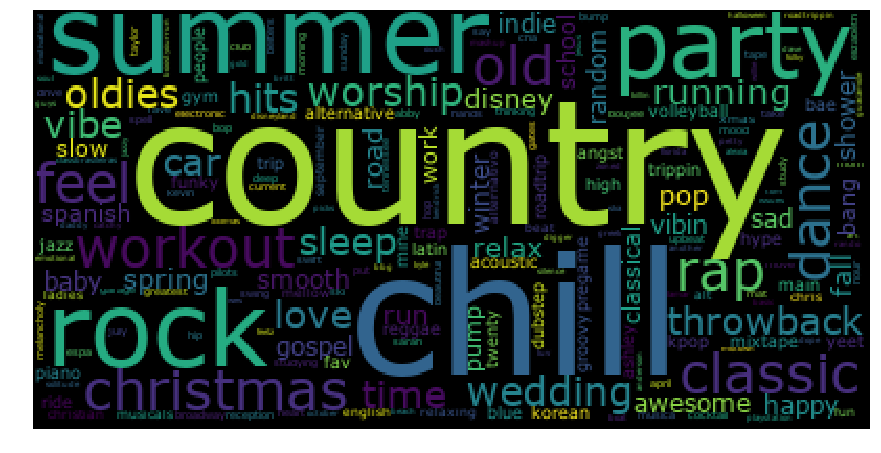

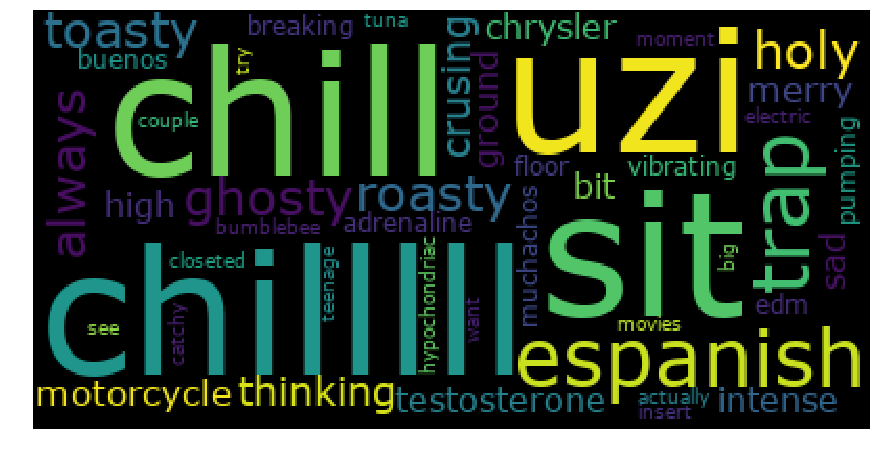

In [10]:
#pip install wordcloud
from wordcloud import WordCloud

def generate_wordcloud(text): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                          relative_scaling = 0.1,
                          ).generate(text)
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

generate_wordcloud(' '.join(playlist_df.playlist_name))

generate_wordcloud(' '.join(playlist_df.playlist_description))

### Using CountVectorizer we create a vocabulary for playlist names and descriptions.  Each playlist in our data frame then get's an extra column that store a list of counts for each word in the vocabulary.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

cv_description = CountVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(1,1), analyzer='word')
dt_mat_description = cv_description.fit_transform(playlist_df.playlist_description)
playlist_df['playlist_description_frequency'] = list(dt_mat_description.toarray())

cv_name = CountVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(1,1), analyzer='word')
dt_mat_name = cv_name.fit_transform(playlist_df.playlist_name)
playlist_df['playlist_name_frequency'] = list(dt_mat_name.toarray())

### Let's vizualize the top 100 words, after clean up, in playlist titles.  This categorical information should be useful in understanding songs that match a playlist in our final model.

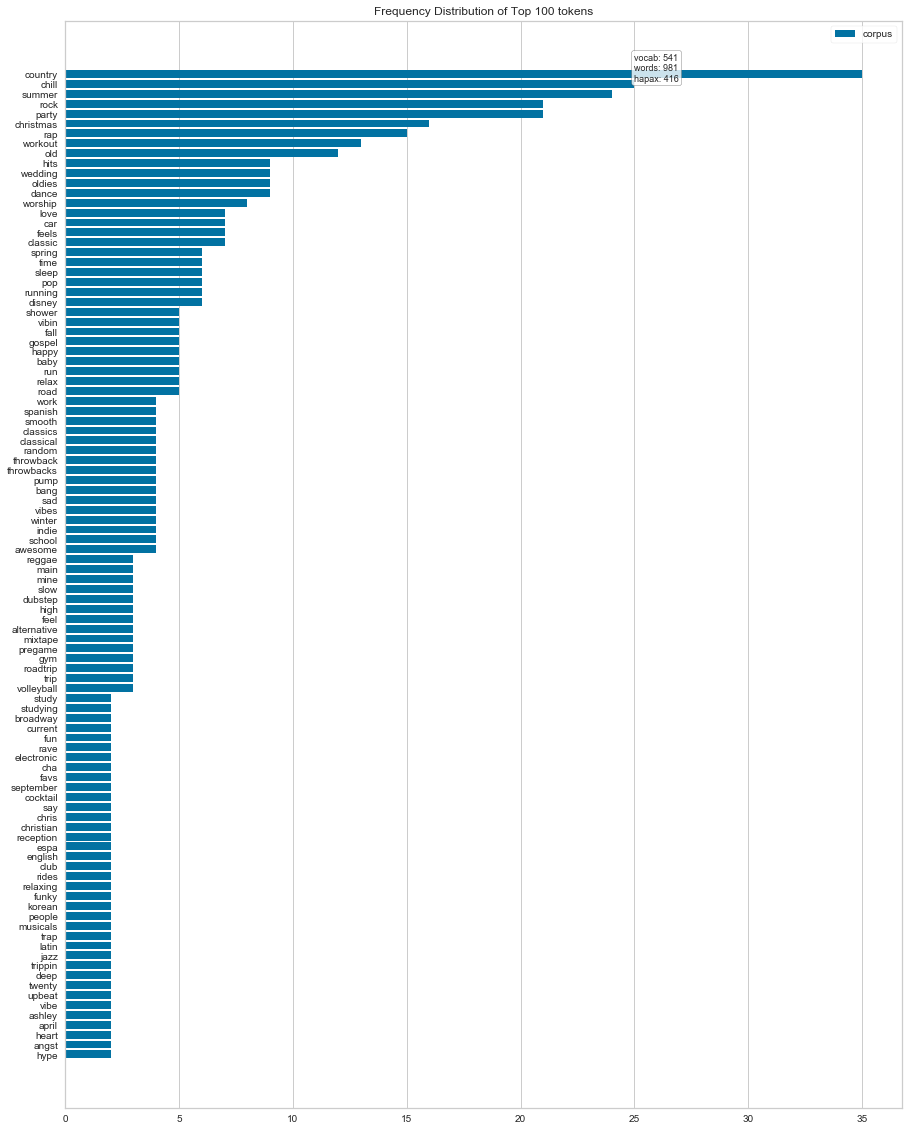

In [12]:
#pip install yellowbrick
from yellowbrick.text import FreqDistVisualizer

plt.figure(figsize=(15,20))
visualizer = FreqDistVisualizer(n=100, features = cv_name.get_feature_names())
visualizer.fit(dt_mat_name)
visualizer.poof()

### And playlist descriptions...  This cell will not run if only 1,000 playlists were initially loaded

ValueError: shape mismatch: objects cannot be broadcast to a single shape

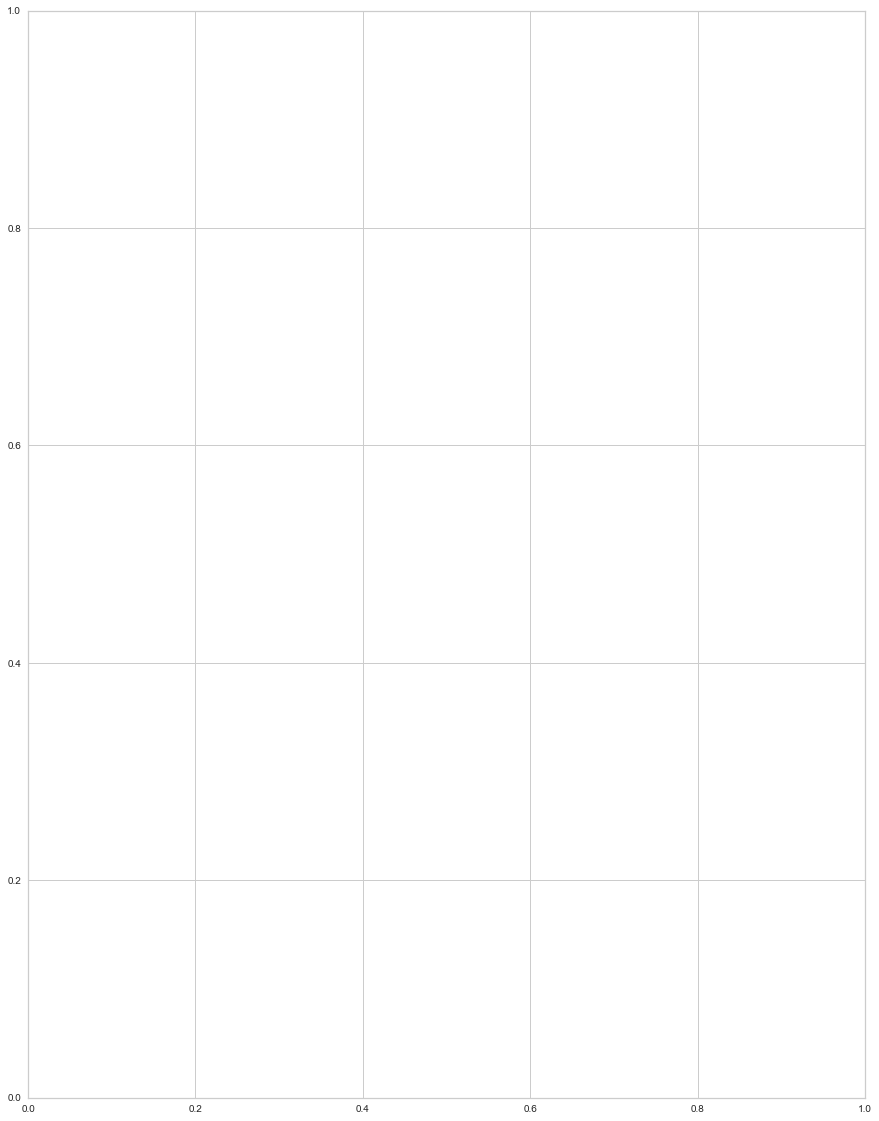

In [18]:
from yellowbrick.text import FreqDistVisualizer

plt.figure(figsize=(15,20))
visualizer = FreqDistVisualizer(n=100, features = cv_description.get_feature_names())
visualizer.fit(dt_mat_description)
visualizer.poof()

### The Tf-idf is a way of penalizing word counts for words that appear frequently across all playlists so that we do not over inflate their significance.

In [19]:
tfidf_transformer = TfidfTransformer()

tfidf_mat_description = tfidf_transformer.fit_transform(dt_mat_description)
playlist_df['playlist_description_tfidf_score']=list(tfidf_mat_description.toarray())

tfidf_mat_name = tfidf_transformer.fit_transform(dt_mat_name)
playlist_df['playlist_name_tfidf_score']=list(tfidf_mat_name.toarray())
playlist_df

,playlist_collaborative,playlist_description,playlist_duration_ms,playlist_modified_at,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_pid,playlist_description_frequency,playlist_name_frequency,playlist_description_tfidf_score,playlist_name_tfidf_score,Popularity,playlist_ave_song_length
0,false,,11532414,1493424000,throwbacks,47,37,6,1,52,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs
1,false,,11656470,1506556800,awesome,23,21,5,1,39,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs
2,false,,14039958,1505692800,korean,51,31,18,1,64,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs
3,false,,28926058,1501027200,mat,107,86,4,1,126,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Long Songs
4,false,,4335282,1401667200,,16,16,7,2,17,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs
5,false,,19156557,1430956800,wedding,71,56,3,1,80,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs
6,false,,3408479,1477094400,put spell,15,13,2,1,16,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs
7,false,,12674796,1509321600,,52,48,38,1,53,7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs
8,false,,9948921,1508976000,bop,37,23,21,2,46,8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs
9,false,,4297488,1501804800,old country,20,18,10,1,21,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs


### Here is a visualization that attempts to flatten out the tf-idf values to 2 dimensions and pick up on any clustering amongst the words.  If a particular group of words often appear together in a particular playlist title, they would appear here as a cluster.

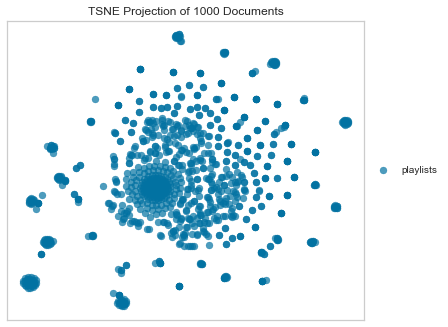

In [15]:
from yellowbrick.text import TSNEVisualizer
tsne = TSNEVisualizer(labels=["playlists"])
tsne.fit(tfidf_mat_name)
tsne.poof()

### We add two extra features to the playlist_df: 'popularity' and a measure of average track length

In [16]:
playlist_df["Popularity"] = np.where(playlist_df.playlist_num_followers > 20, "Many Followers", 'Few Followers')
playlist_df.head()
mean_duration = np.mean(playlist_df["playlist_duration_ms"])
std_duration = np.std(playlist_df["playlist_duration_ms"])
conditions = [playlist_df["playlist_duration_ms"] > mean_duration + 1 * std_duration,
              playlist_df["playlist_duration_ms"] < mean_duration - 1 * std_duration]
choices = ["Long Songs", "Short Songs"]
playlist_df["playlist_ave_song_length"] = np.select(conditions, choices, default = "Average Length Songs")

### Let's see if playlist average song length helps us to see any clustering in the words appearing in playlist titles

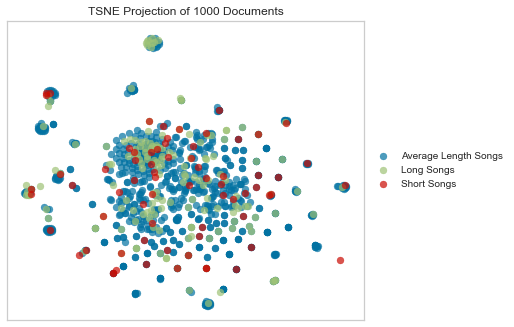

In [17]:
tsne = TSNEVisualizer()
labels = playlist_df["playlist_ave_song_length"]
tsne.fit(tfidf_mat_name, labels)
tsne.poof()

### We intend to try to sucessfully pick up some clustering patterns by better defining playlists by genre / mood as we move forward with this project and do further feature engineering.  Below is some further progress on organizing categorical information for each playlist based on title and discription

In [20]:
bigrams_name_frequency = pd.DataFrame(dt_mat_name.todense(), index=playlist_df.index, columns=cv_name.get_feature_names())
bigrams_name_frequency['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_name_frequency)

bigrams_desc_frequency = pd.DataFrame(tfidf_mat_description.todense(), index=playlist_df.index, columns=cv_description.get_feature_names())
bigrams_desc_frequency['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_desc_frequency)

bigrams_name_tfidf_score = pd.DataFrame(dt_mat_name.todense(), index=playlist_df.index, columns=cv_name.get_feature_names())
bigrams_name_tfidf_score['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_name_tfidf_score)

bigrams_desc_tfidf_score = pd.DataFrame(tfidf_mat_description.todense(), index=playlist_df.index, columns=cv_description.get_feature_names())
bigrams_desc_tfidf_score['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_desc_tfidf_score)

     aaa  abby  acoustic  afternoon  ale  alexia  alright  alt  alternative  \
0      0     0         0          0    0       0        0    0            0   
1      0     0         0          0    0       0        0    0            0   
2      0     0         0          0    0       0        0    0            0   
3      0     0         0          0    0       0        0    0            0   
4      0     0         0          0    0       0        0    0            0   
5      0     0         0          0    0       0        0    0            0   
6      0     0         0          0    0       0        0    0            0   
7      0     0         0          0    0       0        0    0            0   
8      0     0         0          0    0       0        0    0            0   
9      0     0         0          0    0       0        0    0            0   
10     0     1         0          0    0       0        0    0            0   
11     0     0         0          0    0       0    

### We merge the playlists into one that we will use for our baseline model

In [21]:
merged = pd.merge(
    pd.merge(
        tracks_df, playlist_map_df, left_index=True, right_on='track_uri'),
    playlist_df,
    on='playlist_pid')

In [22]:
merged.head()

,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name,playlist_pid,track_uri,playlist_collaborative,playlist_description,...,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_description_frequency,playlist_name_frequency,playlist_description_tfidf_score,playlist_name_tfidf_score,Popularity,playlist_ave_song_length
0,The Coronas,spotify:artist:2tppd6KkhK4ULAd217Ecq1,If I Gave Myself To Someone Else,spotify:album:662PiU3dRsilN0Gp87IiSF,214506,The Long Way,371,spotify:track:000mA0etY38nKdvf1N04af,false,,...,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs
1,Lewis Watson,spotify:artist:40ELTAg7Kg6vbWnlyx2n9R,stones around the sun,spotify:album:4cKBAg2zgjrVF2XefrW4WC,224440,the morning,371,spotify:track:0JGbwcwPV0VfuR4zDcZ9ce,false,,...,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs
2,Jaymes Young,spotify:artist:6QrQ7OrISRYIfS5mtacaw2,We Won't,spotify:album:6MuWCR3WPjwyKhqsTKLZ3z,240586,Feel Something,371,spotify:track:0Zge2Kfo3Yd9JOGnAmVPbb,false,,...,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs
3,John Lucas,spotify:artist:7iEy8zKFtlYIINaxxLIyBk,This Will Be Our Home,spotify:album:2N7sEVVS3jKMJJuJi4v0UF,277160,Promised Land,371,spotify:track:1Sw7fhf7YJCD6GcWW0wETD,false,,...,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs
4,Hozier,spotify:artist:2FXC3k01G6Gw61bmprjgqS,Cherry Wine - Live,spotify:album:36k5aXpxffjVGcNce12GLZ,240147,Hozier,371,spotify:track:1ivHxaGL5ld9VS1zsYc4YN,false,,...,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs


### We create negative samples by making a new data frame in which songs are randomly paired with playlists.  This data frame is then appened to 'merged'.

In [23]:
# Create Negative Samples
negative_samples = pd.DataFrame([])
for pid, df in tqdm(merged.groupby(["playlist_pid"])):
    negative_tracks = tracks_df.drop(df.track_uri).sample(df.shape[0])
    negative_playlist_tracks = pd.concat(
        [
            df.drop(list(tracks_df.columns) + ['track_uri'], axis=1).reset_index(
                drop=True), negative_tracks.reset_index()
        ],
        axis=1)
    negative_playlist_tracks.rename(columns={'index': 'track_uri'}, inplace=True)
    negative_samples = negative_samples.append(negative_playlist_tracks)


### An extra 'match' column indicated whether a song truely belongs to a playlist or not.  This will allow any model we create to train on data with both 'hits' and 'misses'.

In [24]:
# Provide labels
negative_samples['match'] = 0
merged['match'] = 1

In [25]:
negative_samples.head()

,playlist_pid,playlist_collaborative,playlist_description,playlist_duration_ms,playlist_modified_at,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,...,Popularity,playlist_ave_song_length,track_uri,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name,match
0,0,false,,11532414,1493424000,throwbacks,47,37,6,1,...,Few Followers,Average Length Songs,spotify:track:3q0cBVe0GOtgqPUO8vs011,Scotty McCreery,spotify:artist:6ZV6lGY0prbqpTD0Md8i29,Christmas Comin' Round Again,spotify:album:7xY3dwj2terBE72lfMF0U6,246000,Christmas with Scotty McCreery,0
1,0,false,,11532414,1493424000,throwbacks,47,37,6,1,...,Few Followers,Average Length Songs,spotify:track:35TC2nqfmerjo89NurkKjG,Ellie Goulding,spotify:artist:0X2BH1fck6amBIoJhDVmmJ,Dead In The Water,spotify:album:4754Cgv1sdfwTpdVX83xAC,283500,Halcyon,0
2,0,false,,11532414,1493424000,throwbacks,47,37,6,1,...,Few Followers,Average Length Songs,spotify:track:4uhTNbfij6C6G2Ecq4Wlia,Judy Garland,spotify:artist:0hItVPjwJLVZrFqOyIsxPf,Over The Rainbow,spotify:album:1VND54ojnKw7YyWMJdfpLA,167466,The Complete Decca Masters (Plus),0
3,0,false,,11532414,1493424000,throwbacks,47,37,6,1,...,Few Followers,Average Length Songs,spotify:track:7ubzDBkeMcZhUesmGXO951,Missy Elliott,spotify:artist:2wIVse2owClT7go1WT98tk,"...So Addictive (Intro) [feat. Charlene ""Tweet...",spotify:album:20t54K6C80QQH7vbcpfJcP,54066,Miss E...So Addictive,0
4,0,false,,11532414,1493424000,throwbacks,47,37,6,1,...,Few Followers,Average Length Songs,spotify:track:3DnG0TWnSc0fs6quO4sKXU,Green Day,spotify:artist:7oPftvlwr6VrsViSDV7fJY,21 Guns - feat. Green Day And The Cast Of Amer...,spotify:album:3FPrLsPucL8XRylTEnpjG0,281186,21 Guns EP,0


In [26]:
merged.head()

,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name,playlist_pid,track_uri,playlist_collaborative,playlist_description,...,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_description_frequency,playlist_name_frequency,playlist_description_tfidf_score,playlist_name_tfidf_score,Popularity,playlist_ave_song_length,match
0,The Coronas,spotify:artist:2tppd6KkhK4ULAd217Ecq1,If I Gave Myself To Someone Else,spotify:album:662PiU3dRsilN0Gp87IiSF,214506,The Long Way,371,spotify:track:000mA0etY38nKdvf1N04af,false,,...,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs,1
1,Lewis Watson,spotify:artist:40ELTAg7Kg6vbWnlyx2n9R,stones around the sun,spotify:album:4cKBAg2zgjrVF2XefrW4WC,224440,the morning,371,spotify:track:0JGbwcwPV0VfuR4zDcZ9ce,false,,...,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs,1
2,Jaymes Young,spotify:artist:6QrQ7OrISRYIfS5mtacaw2,We Won't,spotify:album:6MuWCR3WPjwyKhqsTKLZ3z,240586,Feel Something,371,spotify:track:0Zge2Kfo3Yd9JOGnAmVPbb,false,,...,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs,1
3,John Lucas,spotify:artist:7iEy8zKFtlYIINaxxLIyBk,This Will Be Our Home,spotify:album:2N7sEVVS3jKMJJuJi4v0UF,277160,Promised Land,371,spotify:track:1Sw7fhf7YJCD6GcWW0wETD,false,,...,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs,1
4,Hozier,spotify:artist:2FXC3k01G6Gw61bmprjgqS,Cherry Wine - Live,spotify:album:36k5aXpxffjVGcNce12GLZ,240147,Hozier,371,spotify:track:1ivHxaGL5ld9VS1zsYc4YN,false,,...,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs,1


In [27]:
negative_samples.head()

,playlist_pid,playlist_collaborative,playlist_description,playlist_duration_ms,playlist_modified_at,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,...,Popularity,playlist_ave_song_length,track_uri,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name,match
0,0,false,,11532414,1493424000,throwbacks,47,37,6,1,...,Few Followers,Average Length Songs,spotify:track:3q0cBVe0GOtgqPUO8vs011,Scotty McCreery,spotify:artist:6ZV6lGY0prbqpTD0Md8i29,Christmas Comin' Round Again,spotify:album:7xY3dwj2terBE72lfMF0U6,246000,Christmas with Scotty McCreery,0
1,0,false,,11532414,1493424000,throwbacks,47,37,6,1,...,Few Followers,Average Length Songs,spotify:track:35TC2nqfmerjo89NurkKjG,Ellie Goulding,spotify:artist:0X2BH1fck6amBIoJhDVmmJ,Dead In The Water,spotify:album:4754Cgv1sdfwTpdVX83xAC,283500,Halcyon,0
2,0,false,,11532414,1493424000,throwbacks,47,37,6,1,...,Few Followers,Average Length Songs,spotify:track:4uhTNbfij6C6G2Ecq4Wlia,Judy Garland,spotify:artist:0hItVPjwJLVZrFqOyIsxPf,Over The Rainbow,spotify:album:1VND54ojnKw7YyWMJdfpLA,167466,The Complete Decca Masters (Plus),0
3,0,false,,11532414,1493424000,throwbacks,47,37,6,1,...,Few Followers,Average Length Songs,spotify:track:7ubzDBkeMcZhUesmGXO951,Missy Elliott,spotify:artist:2wIVse2owClT7go1WT98tk,"...So Addictive (Intro) [feat. Charlene ""Tweet...",spotify:album:20t54K6C80QQH7vbcpfJcP,54066,Miss E...So Addictive,0
4,0,false,,11532414,1493424000,throwbacks,47,37,6,1,...,Few Followers,Average Length Songs,spotify:track:3DnG0TWnSc0fs6quO4sKXU,Green Day,spotify:artist:7oPftvlwr6VrsViSDV7fJY,21 Guns - feat. Green Day And The Cast Of Amer...,spotify:album:3FPrLsPucL8XRylTEnpjG0,281186,21 Guns EP,0


In [28]:
merged.columns

Index(['track_artist_name', 'track_artist_uri', 'track_name',
       'track_album_uri', 'track_duration_ms', 'track_album_name',
       'playlist_pid', 'track_uri', 'playlist_collaborative',
       'playlist_description', 'playlist_duration_ms', 'playlist_modified_at',
       'playlist_name', 'playlist_num_albums', 'playlist_num_artists',
       'playlist_num_edits', 'playlist_num_followers', 'playlist_num_tracks',
       'playlist_description_frequency', 'playlist_name_frequency',
       'playlist_description_tfidf_score', 'playlist_name_tfidf_score',
       'Popularity', 'playlist_ave_song_length', 'match'],
      dtype='object')

In [29]:
negative_samples.columns

Index(['playlist_pid', 'playlist_collaborative', 'playlist_description',
       'playlist_duration_ms', 'playlist_modified_at', 'playlist_name',
       'playlist_num_albums', 'playlist_num_artists', 'playlist_num_edits',
       'playlist_num_followers', 'playlist_num_tracks',
       'playlist_description_frequency', 'playlist_name_frequency',
       'playlist_description_tfidf_score', 'playlist_name_tfidf_score',
       'Popularity', 'playlist_ave_song_length', 'track_uri',
       'track_artist_name', 'track_artist_uri', 'track_name',
       'track_album_uri', 'track_duration_ms', 'track_album_name', 'match'],
      dtype='object')

In [30]:
dataset = merged.append(negative_samples[merged.columns]).sort_values(by=['playlist_pid']).reset_index(drop=True)

In [31]:
dataset.tail(32)

,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name,playlist_pid,track_uri,playlist_collaborative,playlist_description,...,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_description_frequency,playlist_name_frequency,playlist_description_tfidf_score,playlist_name_tfidf_score,Popularity,playlist_ave_song_length,match
134974,Wet,spotify:artist:2i9uaNzfUtuApAjEf1omV8,You're the Best,spotify:album:4vTrbwGUedO7SN3DqNOiYU,177986,Don't You,999,spotify:track:6dHrWj35HXTGvlCasE5VAA,false,,...,34,1,44,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs,1
134975,Astronomyy,spotify:artist:3EpmmPtV7DduqNmeqaADIm,U Make Me Feel Good,spotify:album:5uv9w2zK2LOCGel2Ka0Nu4,219528,There For U,999,spotify:track:6nvThTphqHGVhBffov6TaV,false,,...,34,1,44,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs,1
134976,Ingrid Michaelson,spotify:artist:2vm8GdHyrJh2O2MfbQFYG0,You and I,spotify:album:7o2VLivg95UduHjTMTIEIf,148400,Be OK,999,spotify:track:6zYqyOJuyXDOvWJwKkZ8tg,false,,...,34,1,44,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs,1
134977,Michael Carreon,spotify:artist:5rYJsXiNw3NxHJfOxtmDuC,The Simple Things,spotify:album:5R3YIYy4faDKKUtdBqbE52,263633,Love Adolescent,999,spotify:track:755gQFe8AygwKePVjrMDoj,false,,...,34,1,44,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs,1
134978,Rusty Clanton,spotify:artist:1llFhhYvVi6kC2bfKoPw2k,Light Outside,spotify:album:0IoXIblbl6Gm8mcVoOVctK,227369,Light Outside,999,spotify:track:7du4OH1Ld78PJhC8fDLUJO,false,,...,34,1,44,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs,1
134979,Rusty Clanton,spotify:artist:1llFhhYvVi6kC2bfKoPw2k,The Very Thought of You,spotify:album:6Udmc2m8vKv2Vpqts2iEUV,120372,The Very Thought of You,999,spotify:track:7jxYkSGQdhdDD940NdxiSv,false,,...,34,1,44,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs,1
134980,Spice Girls,spotify:artist:0uq5PttqEjj3IH1bzwcrXF,Wannabe - Radio Edit,spotify:album:3x2jF7blR6bFHtk4MccsyJ,173026,Spice,999,spotify:track:1Je1IMUlBXcx1Fz0WE7oPT,false,,...,34,1,44,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs,0
134981,Timeflies,spotify:artist:6dC0rIJNLSFZwqckLgXJ8p,Stuck With Me,spotify:album:00ylsrQy12tX2jFHVFbOLl,172133,Just For Fun,999,spotify:track:3nMIGUBmSu9QN6SzPLRQeg,false,,...,34,1,44,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs,1
134982,Layla,spotify:artist:04BsVprJtIhl2C4fgPEz4W,Oh My Love,spotify:album:4eTl12dc7uQXvgDhtMgW5p,203675,Yellow Circles EP,

### How well might playlist's track duration alone allow us to make predicitons about the relevancy of particular songs?

In [32]:
# get lists of standard deviations of song length for each playlist for:
# playlists made by humans, playlists randomly generated, playlists with many followers 

num_playlists = dataset["playlist_pid"].nunique()
match_stds = np.full(num_playlists, np.nan)
followers_match_stds = np.array([])
neg_match_stds = np.full(num_playlists, np.nan)

match_ratio = np.full(num_playlists, np.nan)
followers_ratio = np.array([])
neg_match_ratio = np.full(num_playlists, np.nan)


many = 8            #define what is many followers
index = 0
for tup, df in tqdm(dataset.groupby(["playlist_pid", "match"])):
    deviation = np.std(df.track_duration_ms / 60000)
    num_artists = df.track_artist_name.nunique()
    num_tracks = df.track_name.nunique()
    ratio = num_tracks / num_artists
    
    if tup[1] == 1:  #df is full of only matching songs
        match_stds[index] = deviation
        match_ratio[index] = ratio
        if df.playlist_num_followers.iloc[0] > many:
            followers_match_stds = np.append(followers_match_stds, deviation)
            followers_ratio = np.append(followers_ratio, ratio)
        index += 1
    else:            #df is full of non_matching songs
        neg_match_stds[index] = deviation
        neg_match_ratio[index] = ratio

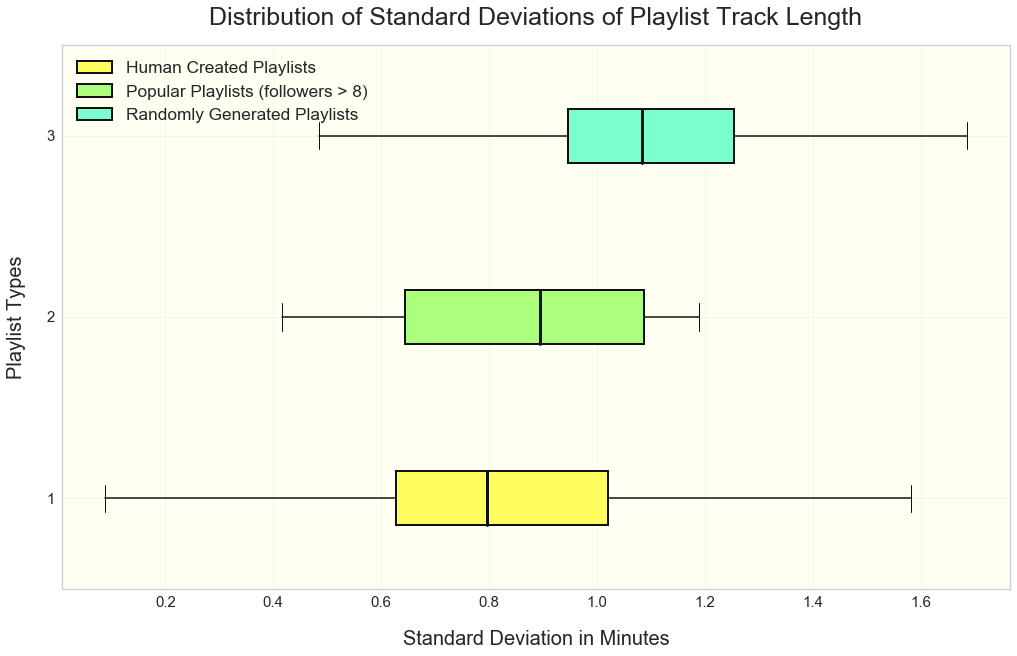

In [33]:
fig, ax = plt.subplots(1,1, figsize = (17, 10))

boxes = ax.boxplot([match_stds, followers_match_stds, neg_match_stds], 
           showfliers = False, 
           vert = False,
           patch_artist = True,
           boxprops = {"lw": 2}, 
           whiskerprops = {"linewidth": 1.5},
           medianprops = {"linewidth": 3, "color": "k"}
          )
colors = ['#fffc5e', "#acff7c", "#7cffce"]
for patch, color in zip(boxes['boxes'], colors): 
    patch.set_facecolor(color)
ax.set_facecolor((1,1,.95))
ax.tick_params(labelsize = 15)
ax.legend([boxes["boxes"][0], boxes["boxes"][1], boxes["boxes"][2]], 
          ["Human Created Playlists","Popular Playlists (followers > " + str(many)+ ")", 
           "Randomly Generated Playlists"], 
          fontsize = "x-large", loc = "upper left")
ax.set_xlabel("Standard Deviation in Minutes", fontsize = 20, labelpad=20)
ax.set_ylabel("Playlist Types", fontsize = 20, labelpad=20)
ax.grid(alpha = .2)
ax.set_title("Distribution of Standard Deviations of Playlist Track Length", fontsize = 25, pad=20);

fig.savefig("fig1.png")

### What can we say about the ratio of tracks to artists across our playlists in our dataset?

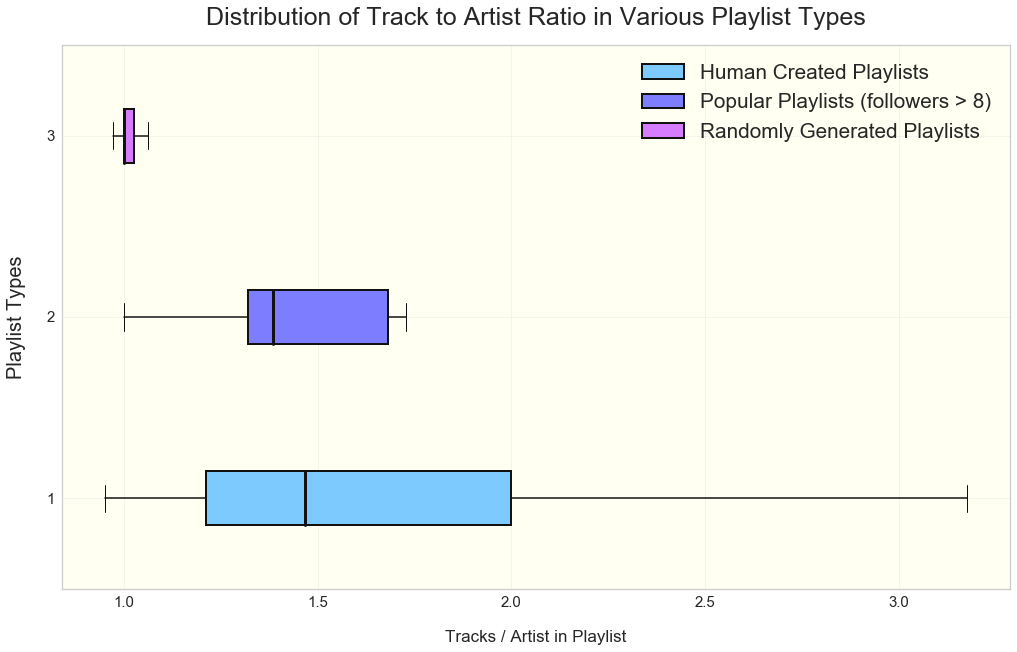

In [34]:
fig, ax = plt.subplots(1,1, figsize = (17, 10))

boxes = ax.boxplot([match_ratio, followers_ratio, neg_match_ratio], 
           showfliers = False, 
           vert = False,
           patch_artist = True,
           boxprops = {"lw": 2}, 
           whiskerprops = {"linewidth": 1.5},
           medianprops = {"linewidth": 3, "color": "k"}
          )
colors = ['#7ccaff', "#7c7eff", "#d57cff"]
for patch, color in zip(boxes['boxes'], colors): 
    patch.set_facecolor(color)
ax.set_facecolor((1,1,.95))
ax.tick_params(labelsize = 15)
ax.legend([boxes["boxes"][0], boxes["boxes"][1], boxes["boxes"][2]], 
          ["Human Created Playlists","Popular Playlists (followers > " + str(many)+ ")", 
           "Randomly Generated Playlists"], 
          fontsize = "xx-large")
ax.set_xlabel("Tracks / Artist in Playlist", fontsize = 17, labelpad=20)
ax.set_ylabel("Playlist Types", fontsize = 20, labelpad=20)
ax.grid(alpha = .2)
ax.set_title("Distribution of Track to Artist Ratio in Various Playlist Types", fontsize = 25, pad=20);
fig.savefig("fig2.png")

### Now to split the dataset into train and test and get a baseline model running 

In [38]:
# Include the features in the list below
features = [
    'playlist_duration_ms', 'playlist_num_albums', 'playlist_num_artists',
    'playlist_num_edits', 'playlist_num_followers', 'playlist_num_tracks',
    'playlist_pid', 'track_duration_ms'
]
data_x = dataset[features]
data_y = dataset.match
X_train, X_test, y_train, y_test = train_test_split(
    data_x,
    data_y,
    test_size=0.1,
    stratify=dataset.playlist_pid,
    random_state=42,
    shuffle=True)

The dataset has been split, which is great. However, in order to better simulate real world situations, we need to build a test set with a lot more negative samples than there are positive samples. In the split above, there are equal number of positive and negative samples, so it'll be easy for the algorithm to perform. Below we build a more robust test set

In [39]:
X_train.columns

Index(['playlist_duration_ms', 'playlist_num_albums', 'playlist_num_artists',
       'playlist_num_edits', 'playlist_num_followers', 'playlist_num_tracks',
       'playlist_pid', 'track_duration_ms'],
      dtype='object')

In [40]:
X_test_refined.head()

NameError: name 'X_test_refined' is not defined

In [41]:
y_test.head()
# y_test[y_test == 1].head()

103377    0
109111    1
73892     1
89166     0
14465     1
Name: match, dtype: int64

In [42]:
dataset.loc[X_test.head().index]

,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name,playlist_pid,track_uri,playlist_collaborative,playlist_description,...,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_description_frequency,playlist_name_frequency,playlist_description_tfidf_score,playlist_name_tfidf_score,Popularity,playlist_ave_song_length,match
103377,Wolfmother,spotify:artist:3yEnArbNHyTCwMRvD9SBy4,Pretty Peggy,spotify:album:36I0DNppSxHcv2k71Fy3gB,229000,Victorious,769,spotify:track:7xGGP3TRw7xeZQ2iYDphYr,false,,...,67,1,157,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Long Songs,0
109111,Mike WiLL Made-It,spotify:artist:0NWbwDZY1VkRqFafuQm6wk,23,spotify:album:7Dx0pz51iSbIcbwHqLNjG4,252520,23,815,spotify:track:1XHjU0TGIgl5lMFKAF25Y3,false,,...,6,1,189,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Long Songs,1
73892,Jamie Foxx,spotify:artist:7LnaAXbDVIL75IVPnndf7w,Fall For Your Type,spotify:album:3T1fgMprST5C4hhl19Xv40,269533,Best Night Of My Life,558,spotify:track:0hRPRbA2B1CYmGNhWhFjwF,false,,...,19,1,47,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs,1
89166,Kiesza,spotify:artist:4zxvC7CRGvggq9EWXOpwAo,Hideaway - Gorgon City Remix,spotify:album:5e0Qu86n1r9AhtmsYxOpb8,311293,Hideaway,665,spotify:track:6E2TXooRkBxumkKwSLo6TG,false,,...,16,2,61,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Average Length Songs,0
14465,Sublime,spotify:artist:0EdvGhlC1FkGItLOWQzG4J,What I Got,spotify:album:4R3tXoorBpHji6Jdms8a4Q,171066,Sublime,115,spotify:track:5nkYHBWXu7KCgcdwP6jcB1,false,,...,48,4,194,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Few Followers,Long Songs,1


In [43]:
# 1. Calculate metric only on test set using the positive samples
#     a. Obtain unique playlists in the test set
#     b. For each playlist, obtain the positve songs.
#     c. Set both `target` and `prediction` as lists of the positive songs
#     d. For each playlist, calculate the r_precision. r_precision comes from the metrics.py file in the repo.

# 2. Train the X_train on the classifier. Obtain predictions for X_test

# 3. Repeat 1 above, now setting `predictions` as the list of songs "ranked by probability".

# 4. Calculate the r_precision metric based on your predicitons!

### Here is a check to see if R-Precision returns 1.0 given a set of perfect predictions

In [45]:
r_precisions = []
for pid, df in tqdm(X_test.groupby(["playlist_pid"])):
    probs = y_test.loc[df.index]  # change y_test to the output probs from clf
    targets = dataset.loc[probs[probs == 1].index].track_uri
    predictions = dataset.loc[probs[probs > 0.5].index].track_uri.unique()
    if len(targets) > 0:
        r_precisions.append(r_precision(targets, predictions))
np.mean(r_precisions)    

1.0

In [46]:
X_train_norm = (X_train-X_train.mean())/X_train.std()
X_test_norm = (X_test-X_test.mean())/X_test.std()

In [47]:
X_train_norm.head()

,playlist_duration_ms,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_pid,track_duration_ms
58405,1.512633,1.419332,0.731253,1.220875,0.027585,1.297279,-0.231835,0.498041
113911,1.622161,0.810658,0.677761,0.974816,-0.055875,1.548164,1.182737,-0.336892
18094,0.484850,0.770080,1.159185,1.783296,-0.055875,0.278058,-1.293638,-0.913399
62296,0.482472,0.729502,1.185931,1.431783,0.027585,0.434861,-0.141023,-0.505427
107132,-0.349849,-0.000906,0.062608,-0.642144,-0.055875,-0.411876,1.032548,0.610896


In [48]:
X_test_norm.head()

,playlist_duration_ms,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_pid,track_duration_ms
103377,0.564549,1.154328,1.692218,1.360552,-0.055803,0.700257,0.911004,-0.072231
109111,1.127322,2.006484,2.387366,-0.783313,-0.055803,1.202244,1.071768,0.233024
73892,-1.002629,-0.915195,-0.874483,-0.326424,-0.055803,-1.025321,0.173585,0.453828
89166,-0.907306,-0.549985,-0.259544,-0.431860,-0.027791,-0.805702,0.547537,0.995812
14465,1.153917,1.357222,1.130752,0.692791,0.028231,1.280679,-1.374645,-0.824129


In [49]:
lr_clf = LogisticRegression()
lr_clf = lr_clf.fit(X_train_norm, y_train)

In [50]:
# y_prob = lr_clf.predict_proba(X_test)
y_prob = pd.DataFrame(lr_clf.predict_proba(X_test_norm), index=y_test.index)

In [51]:
y_prob.head(10)

,0,1
103377,0.499968,0.500032
109111,0.500350,0.499650
73892,0.503015,0.496985
89166,0.506563,0.493437
14465,0.495209,0.504791
19251,0.497174,0.502826
43710,0.496807,0.503193
99171,0.498607,0.501393
16454,0.503901,0.496099
107247,0.488076,0.511924


In [52]:
y_test.head(10)

103377    0
109111    1
73892     1
89166     0
14465     1
19251     1
43710     0
99171     0
16454     0
107247    0
Name: match, dtype: int64

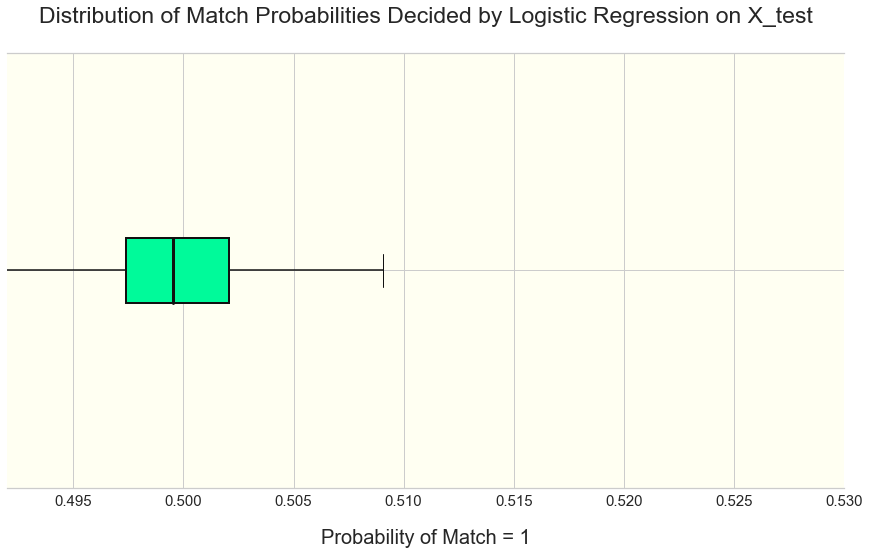

In [55]:
#Strength of predictions

fig, ax = plt.subplots(1,1, figsize = (15,8))
boxes = ax.boxplot([y_prob.iloc[: ,0]], 
           labels = [""],
           vert = False,
           patch_artist = True,
           boxprops = {"lw": 2}, 
           whiskerprops = {"linewidth": 1.5},
           medianprops = {"linewidth": 3, "color": "k"},
           sym = "+"
          )
colors = ['mediumspringgreen']
for patch, color in zip(boxes['boxes'], colors): 
    patch.set_facecolor(color)
ax.set_facecolor((1,1,.95))
ax.tick_params(labelsize = 15)
ax.set_xlabel("Probability of Match = 1", fontsize = 20, labelpad=20)
ax.set_xlim(.492, .53)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.set_title("Distribution of Match Probabilities Decided by Logistic Regression on X_test", fontsize = 23, pad=30);
fig.savefig("fig3.png")

In [56]:
y_pred = y_prob.idxmax(axis=1)

In [57]:
r_precisions = []
for pid, df in tqdm(X_test.groupby(["playlist_pid"])):
    labels = y_test.loc[df.index]  # change y_test to the output probs from clf
    preds = y_pred.loc[df.index]
    targets = dataset.loc[labels[labels == 1].index].track_uri
    predictions = dataset.loc[preds[preds == 1].index].track_uri.unique()
    if len(targets) > 0:
        r_precisions.append(r_precision(targets, predictions))
np.mean(r_precisions)    

0.4277164488217525

In [58]:
X_test_refined = pd.DataFrame([])
r_precisions = []
pbar = tqdm(X_test.groupby(['playlist_pid']))
for pid, df in pbar:
    labels = y_test.loc[df.index]
    targets = dataset.loc[labels.index].track_duration_ms
    positive_targets = dataset.loc[labels[labels == 1].index].index
    # trained_idx = set(y_train[y_train == 1].index) - set(df.index)
    # Obtain all tracks from dataset which are not in the playlist under consideration
    #     negative_tracks = dataset.loc[X_train[(X_train.playlist_pid != pid)]
    #                                   .index].track_duration_ms
    negative_tracks = dataset.loc[X_test[(X_test.playlist_pid != pid)]
                                  .index].track_duration_ms
    # trained_tracks = X_train.loc[y_train.loc[y_train[y_train==1].index].index].track_uri
    new_df = df.drop('track_duration_ms', axis=1)
    new_test = negative_tracks.append(targets)
    new_df = pd.concat([new_df.head(1)] * len(new_test))
    test_playlist_tracks = pd.concat(
        [new_df.reset_index(drop=True), new_test.reset_index(drop=True)],
        axis=1).set_index(new_test.index)
    # from IPython.core.debugger import set_trace; set_trace()
    test_playlist_tracks = (test_playlist_tracks-test_playlist_tracks.mean())/(test_playlist_tracks.std()+1e-8)
    X_test_refined = X_test_refined.append(test_playlist_tracks)
    y_prob = pd.DataFrame(
        lr_clf.predict_proba(test_playlist_tracks),
        index=test_playlist_tracks.index)
    y_prob = y_prob.sort_values(by=[1], ascending=False)
    if len(positive_targets) > 0:
        r_precisions.append(r_precision(positive_targets, y_prob.index))
    pbar.set_description("{}".format(np.mean(r_precisions)))
    # from IPython.core.debugger import set_trace; set_trace()

KeyboardInterrupt: 

In [ ]:
np.unique(r_precisions, return_counts=True)

In [ ]:
np.mean(r_precisions)

Question: Do playlist and track duration interact to influence whether a song should belong to a playlist `(match=1)` or whether a song should not belong to a playlist `(match=0)`?

In [ ]:
(dataset[dataset.match==1].playlist_duration_ms/dataset[dataset.match==1].playlist_num_tracks)

In [ ]:
plt.scatter(dataset[dataset.match == 1].playlist_duration_ms /
            dataset[dataset.match == 1].playlist_num_tracks,
            dataset[dataset.match == 1].track_duration_ms)
plt.scatter(dataset[dataset.match == 0].playlist_duration_ms /
            dataset[dataset.match == 0].playlist_num_tracks,
            dataset[dataset.match == 0].track_duration_ms)
plt.xlabel('Average Track Duration')
plt.ylabel('Track Duration')


A trend which might not be that strong to notice is that as the average track duration increases for a playlist, the propensity to see a track of long duration increases. However, this isn't the case with negative sample playlists, where in playlist of short length very long tracks can still be detected.

In [ ]:
plt.hist(dataset[dataset.match==1].playlist_duration_ms)
plt.hist(dataset[dataset.match==0].playlist_duration_ms)